# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

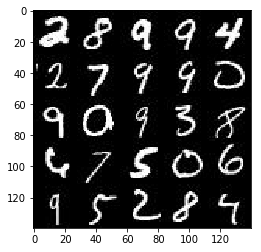

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

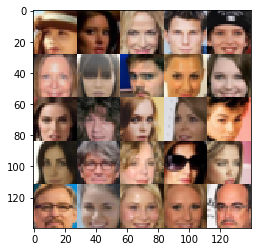

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Define Custom Activation Function

In [10]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [249]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # assume that images have shape 28x28x?
        
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        layer1_act = leaky_relu(layer1)
        # 14x14
        
        layer2 = tf.layers.conv2d(layer1_act, 256, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=True)
        layer2_act = leaky_relu(layer2_bn)
        # 7x7
        
        layer2_rs = tf.reshape(layer2_act, (-1, 7*7*256))
        
        logits = tf.layers.dense(layer2_rs, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [250]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1_rs = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1_bn = tf.layers.batch_normalization(layer1_rs, training=is_train)
        layer1_act = leaky_relu(layer1_bn)
        # 7x7

        layer2 = tf.layers.conv2d_transpose(layer1_act, 128, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=is_train)
        layer2_act = leaky_relu(layer2_bn)
        # 14x14
    
        logits = tf.layers.conv2d_transpose(layer2_act, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x?

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [251]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [252]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_ = tf.trainable_variables()
    g_vars = [var for var in vars_ if var.name.startswith('generator')]
    d_vars = [var for var in vars_ if var.name.startswith('discriminator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [253]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [254]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 4, input_z, image_channels, data_image_mode)
                    
    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 3.5668
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 9.6657
Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 13.6559
Epoch 1/2... Discriminator Loss: 4.4392... Generator Loss: 0.1230
Epoch 1/2... Discriminator Loss: 0.5103... Generator Loss: 5.3299
Epoch 1/2... Discriminator Loss: 2.2928... Generator Loss: 0.3405
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 2.1870
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 4.2321
Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 4.1255
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 4.9990


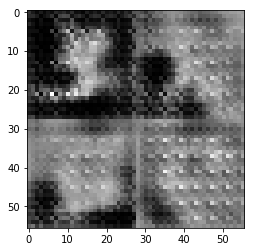

Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 3.9878
Epoch 1/2... Discriminator Loss: 5.3905... Generator Loss: 11.0864
Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 6.0165
Epoch 1/2... Discriminator Loss: 0.4414... Generator Loss: 4.4165
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 9.0484
Epoch 1/2... Discriminator Loss: 0.5628... Generator Loss: 7.3533
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 3.6594
Epoch 1/2... Discriminator Loss: 0.3878... Generator Loss: 5.1434
Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 2.8359
Epoch 1/2... Discriminator Loss: 0.4530... Generator Loss: 4.2107


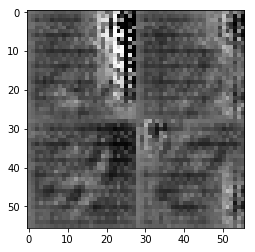

Epoch 1/2... Discriminator Loss: 0.3656... Generator Loss: 7.3055
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 6.1028
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 8.5567
Epoch 1/2... Discriminator Loss: 2.4537... Generator Loss: 5.3735
Epoch 1/2... Discriminator Loss: 2.4546... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 2.1560
Epoch 1/2... Discriminator Loss: 1.9217... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 0.4564... Generator Loss: 3.2386
Epoch 1/2... Discriminator Loss: 0.5209... Generator Loss: 3.3966
Epoch 1/2... Discriminator Loss: 0.4531... Generator Loss: 4.2436


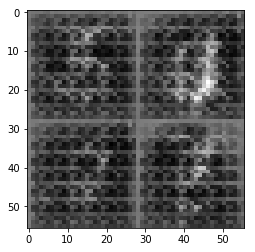

Epoch 1/2... Discriminator Loss: 0.4206... Generator Loss: 4.5990
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 4.4157
Epoch 1/2... Discriminator Loss: 4.9359... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 3.1935
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 3.5517
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 4.1280
Epoch 1/2... Discriminator Loss: 0.5652... Generator Loss: 2.8520
Epoch 1/2... Discriminator Loss: 0.5110... Generator Loss: 3.9384
Epoch 1/2... Discriminator Loss: 2.5552... Generator Loss: 0.1945


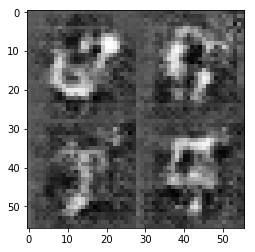

Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 3.2398
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 3.3647
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 2.3546
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 2.3014
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 2.1558
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.7583
Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.5833
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 1.8434
Epoch 2/2... Discriminator Loss: 0.4860... Generator Loss: 2.9567
Epoch 2/2... Discriminator Loss: 1.5083... Generator Loss: 3.5911


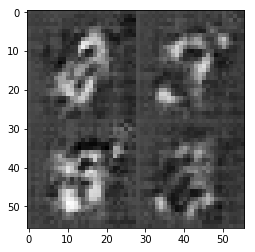

Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 2.2721
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 2.1321
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 3.8919
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.7129
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 3.4167
Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.7164
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 2.4060
Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 2.0546
Epoch 2/2... Discriminator Loss: 0.4605... Generator Loss: 2.8528
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.9540


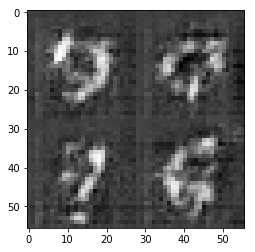

Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 2.7627
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 3.0101
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 2.4879
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 2.7220
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 2.1222
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 2.9708
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.4220... Generator Loss: 3.0460
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 3.0972
Epoch 2/2... Discriminator Loss: 5.9879... Generator Loss: 8.9181


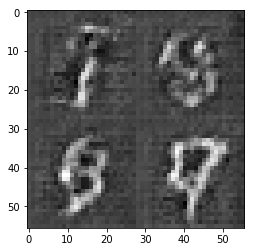

Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3435
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 4.3102
Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.7814
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.1523
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 1.9214
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.3187
Epoch 2/2... Discriminator Loss: 1.7932... Generator Loss: 4.7848
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 2.2275
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 2.2317


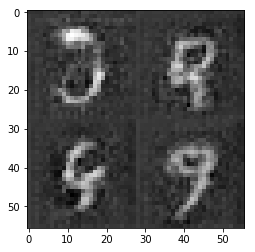

Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 2.4670
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.8332
Epoch 2/2... Discriminator Loss: 0.4319... Generator Loss: 2.6977
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 2.7350
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 3.4570
Epoch 2/2... Discriminator Loss: 2.7412... Generator Loss: 5.1545
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 2.2504
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 3.1044
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.2609


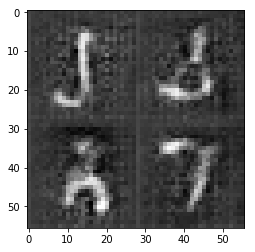

Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 2.2498
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 2.9885
Epoch 2/2... Discriminator Loss: 0.6526... Generator Loss: 2.2874


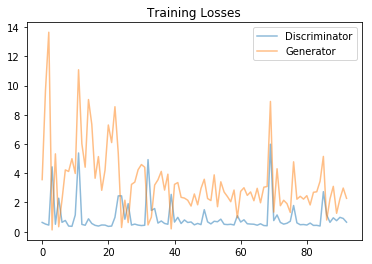

In [257]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9922... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 4.3089
Epoch 1/1... Discriminator Loss: 5.2251... Generator Loss: 0.1192
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.9531
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 7.7976
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 6.5438
Epoch 1/1... Discriminator Loss: 7.8705... Generator Loss: 13.9143
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 4.7371
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 3.0068


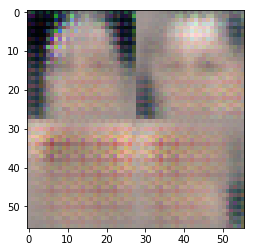

Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.6548
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 5.9642
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.0683
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 10.8309
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 6.5163
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 5.1896
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 5.9793
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 5.5610
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 2.9291


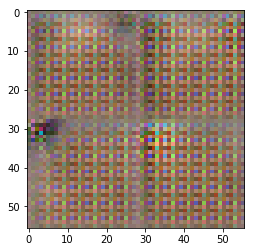

Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 3.0195
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 2.9314
Epoch 1/1... Discriminator Loss: 2.3964... Generator Loss: 4.4165
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 8.4488
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 2.3302
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 3.0520
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 7.7708


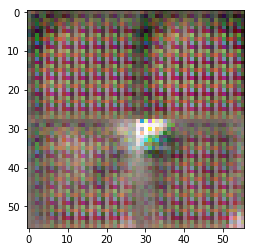

Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 3.4874
Epoch 1/1... Discriminator Loss: 3.5173... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.8476... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 2.1749... Generator Loss: 2.3312
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 3.5674
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 2.8851
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 2.4307
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 3.6101


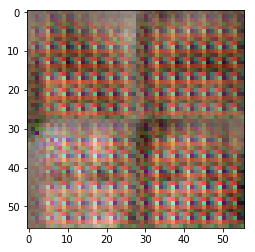

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 4.5428
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 2.0502... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 1.9562... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 2.3479... Generator Loss: 2.6957
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 2.4877... Generator Loss: 0.2209
Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8219


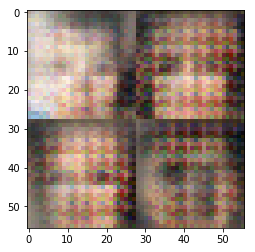

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.8943... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.7585... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 2.9712... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 2.3411... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 2.0267... Generator Loss: 1.7798


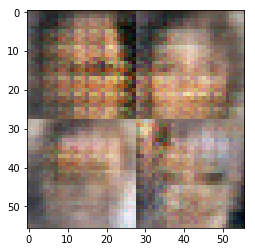

Epoch 1/1... Discriminator Loss: 2.4440... Generator Loss: 2.8861
Epoch 1/1... Discriminator Loss: 2.0707... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 2.7703
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 2.6943
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 3.3381


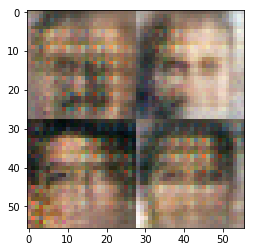

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.9869
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 4.6988
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 1.9591
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 2.5451... Generator Loss: 0.2175
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.2062


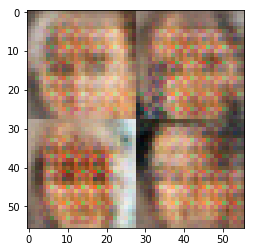

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 2.8199
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.0185
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 3.4687
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.2684
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 2.4815... Generator Loss: 0.2023


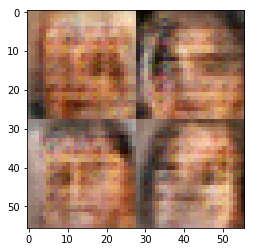

Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 4.2158
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 2.6303
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 2.0823
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.9869
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 0.2719


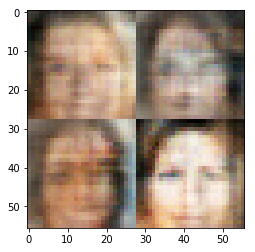

Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 1.5215
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 3.2194
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 4.9016
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 2.8009


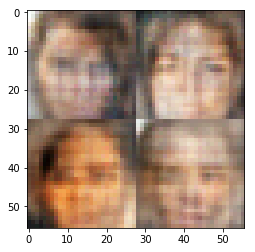

Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 2.1070... Generator Loss: 0.2506
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5707


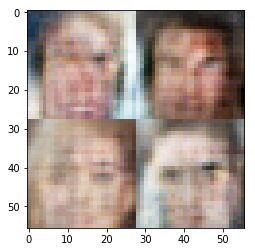

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 2.1226
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.0501


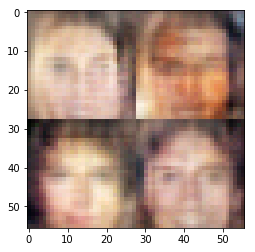

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.8805... Generator Loss: 2.5086
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.6450
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5467


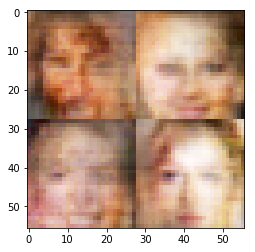

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 1.2258


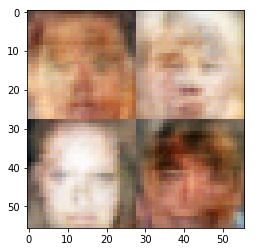

Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 2.5903
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.4420


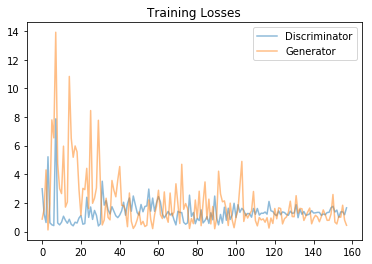

In [259]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.